LLMs can significantly enhance chatbot functionality by associating broader intents with documents from a Knowledge Base (KB) instead of specific questions and answers. This approach streamlines intent management and generates more tailored responses to user inquiries.

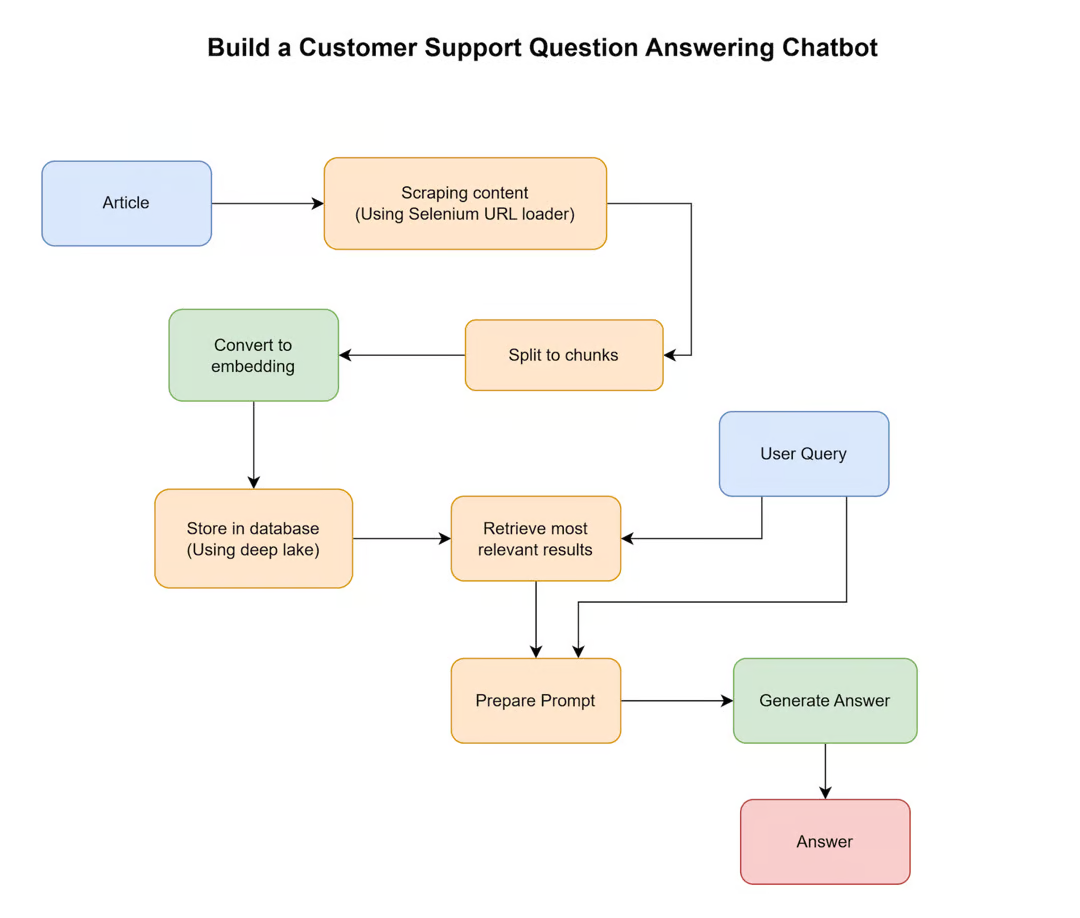

It is important to note that there is always a risk of generating hallucinations or false information when using LLMs. Although this might not be acceptable for many customers support use cases, the chatbot can still be helpful for assisting operators in drafting answers that they can double-check before sending them to the user.

As we’re going to use the SeleniumURLLoader LangChain class, and it uses the unstructured and selenium Python library, let’s install it using pip. It is recommended to install the latest version of the library. Nonetheless, please be aware that the code has been tested specifically on version 0.7.7.

In [1]:
from langchain.embeddings import OllamaEmbeddings
from langchain.vectorstores import DeepLake
from langchain.text_splitter import CharacterTextSplitter
from langchain.document_loaders import SeleniumURLLoader
from langchain import PromptTemplate

/home/orzanescu/anaconda3/envs/langChainENV/lib/python3.11/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.21) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [2]:
# we'll use information from the following articles
urls = ['https://beebom.com/what-is-nft-explained/',
        'https://beebom.com/how-delete-spotify-account/',
        'https://beebom.com/how-download-gif-twitter/',
        'https://beebom.com/how-use-chatgpt-linux-terminal/',
        'https://beebom.com/how-delete-spotify-account/',
        'https://beebom.com/how-save-instagram-story-with-music/',
        'https://beebom.com/how-install-pip-windows/',
        'https://beebom.com/how-check-disk-usage-linux/']

### 1: Split the documents into chunks and compute their embeddings
We load the documents from the provided URLs and split them into chunks using the CharacterTextSplitter with a chunk size of 1000 and no overlap:

In [3]:
# use the selenium scraper to load the documents
loader = SeleniumURLLoader(urls=urls)
docs_not_splitted = loader.load()

# we split the documents into smaller chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(docs_not_splitted)

Created a chunk of size 1226, which is longer than the specified 1000


Next, we compute the embeddings using OpenAIEmbeddings and store them in a Deep Lake vector store on the cloud. In an ideal production scenario, we could upload a whole website or course lesson on a Deep Lake dataset, allowing for search among even thousands or millions of documents.

In [ ]:

embeddings = OllamaEmbeddings()

# create Deep Lake dataset
# TODO: use your organization id here. (by default, org id is your username)
my_activeloop_org_id = "georgeasro"
my_activeloop_dataset_name = "langchain_course_customer_support_example"
dataset_path = f"hub://{my_activeloop_org_id}/{my_activeloop_dataset_name}"
db = DeepLake(dataset_path=dataset_path, embedding_function=embeddings)

# add documents to our Deep Lake dataset
db.add_documents(docs)

To retrieve the most similar chunks to a given query, we can use the similarity_search method of the Deep Lake vector store:

In [ ]:
# let's see the top relevant documents to a specific query
query = "how to check disk usage in linux?"
docs = db.similarity_search(query)
print(docs[0].page_content)

We will create a prompt template that incorporates role-prompting, relevant Knowledge Base information, and the user's question:

In [6]:
# let's write a prompt for a customer support chatbot that
# answer questions using information extracted from our db
template = """You are an exceptional customer support chatbot that gently answer questions.

You know the following context information.

{chunks_formatted}

Answer to the following question from a customer. Use only information from the previous context information. Do not invent stuff.

Question: {query}

Answer:"""

prompt = PromptTemplate(
    input_variables=["chunks_formatted", "query"],
    template=template,
)

To generate a response, we first retrieve the top-k (e.g., top-3) chunks most similar to the user query, format the prompt, and send the formatted prompt to the Ollama2 model with a temperature of 0.

In [ ]:
# the full pipeline
from langchain_community.llms import Ollama
# user question
query = "How to check disk usage in linux?"

# retrieve relevant chunks
docs = db.similarity_search(query)
retrieved_chunks = [doc.page_content for doc in docs]

# format the prompt
chunks_formatted = "\n\n".join(retrieved_chunks)
prompt_formatted = prompt.format(chunks_formatted=chunks_formatted, query=query)

# generate answer
llm = Ollama(model="llama2", temperature=0)
answer = llm(prompt_formatted)
print(answer)